In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

In [2]:
X, y = load_iris(return_X_y=True)
X = X[:, :2]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=48,
                                                    stratify=y)
X_train.shape, X_test.shape

((120, 2), (30, 2))

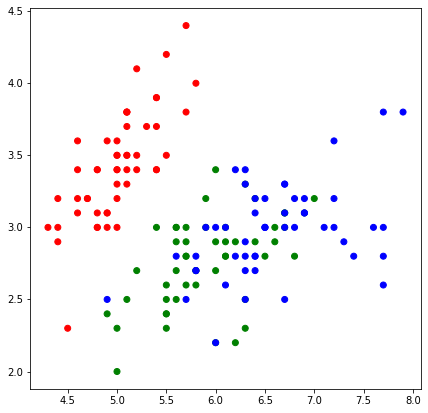

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

In [5]:
def e_metrics(x1, x2):
    
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

In [6]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):            
           
            distance = e_metrics(x, x_train[i])            
            
            test_distances.append((distance, y_train[i]))        
        
        classes = {class_item: 0 for class_item in set(y_train)}
        
#        В следующем цикле вместо количества соседей разных классов подсчитываю сумму весов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1 / (d[0]+1)

        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

In [7]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [8]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .1

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    print(np.c_[xx.ravel(), yy.ravel()].shape)

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)
    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

In [9]:
k = 8

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 8: 0.867


(2464, 2)


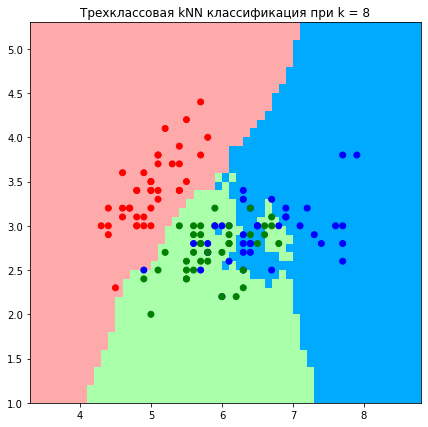

Wall time: 1.92 s


In [10]:
%%time
get_graph(X_train, y_train, k)

2.	*Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [11]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, random_state=1)

In [12]:
X.shape, y.shape

((100, 2), (100,))

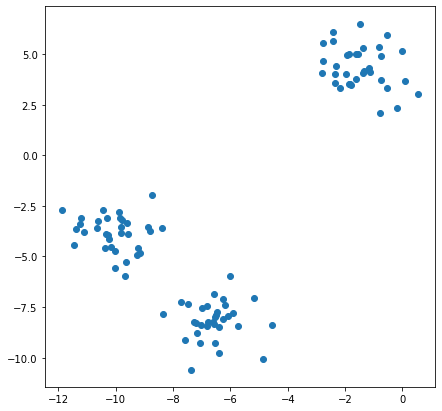

In [13]:
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1]);

In [14]:
def kmeans(data, k, max_iterations, min_distance):    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # Создадим словарь для кластеризации
        clusters = {i: [] for i in range(k)}
        
        # кластеризуем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            cluster = distances.index(min(distances))
            clusters[cluster].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for cluster in clusters:
            centroids[cluster] = np.mean(clusters[cluster], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.linalg.norm(centroids[centroid] - old_centroids[centroid], ord=2) > min_distance:
                optimal = False
                break
        
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, clusters

In [15]:
def visualize(centroids, clusters):
    colors = ['r', 'g', 'b', 'orange', 'y']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for cluster_item in clusters:
        for x in clusters[cluster_item]:
            plt.scatter(x[0], x[1], color=colors[cluster_item])
            
    plt.show()

In [16]:
# clusters[0]

In [17]:
def msd_in_cluster(centroids, clusters):
#     res = 0
#     for i in range(len(centroids)):
#         res_in = 0
#         for el in clusters[i]:
#             res_in += np.sum(np.square(el - centroids[i]))
#         res += res_in / len(clusters[i])
        
    res = sum([np.mean([sum((el - centroids[i])**2) for el in clusters[i]]) for i in range(len(centroids))])
    
    return round(res, 3)

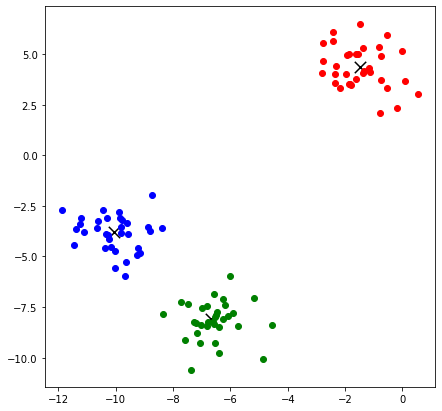

Wall time: 639 ms


In [18]:
%%time
max_iterations = 3
min_distance = 1e-4
k = 3

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

In [19]:
msd_in_cluster(centroids, clusters)

4.699

In [20]:
max_iterations = 7
min_distance = 1e-4
msd_list = []

for k in range(1,11):

    centroids, clusters = kmeans(X, k, max_iterations, min_distance)
    msd_list.append(msd_in_cluster(centroids, clusters))

In [21]:
msd_list

[41.182, 10.882, 4.682, 4.834, 4.715, 5.692, 5.481, 5.62, 5.915, 5.731]

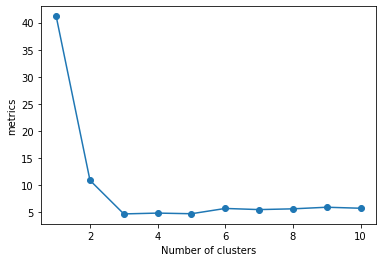

In [22]:
plt.scatter(range(1, len(msd_list)+1), msd_list)
plt.plot(range(1, len(msd_list)+1), msd_list)
plt.xlabel('Number of clusters')
plt.ylabel('metrics')
plt.show()

Начиная с k=3 среднее квадратичное внутрикластерное расстояние значительно не меняется.